In [1]:
import os

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
os.chdir('../..')
os.getcwd()

'/home/max/mcrc-cetuximab-analysis'

In [36]:
log_tpms = pd.read_csv('data/log_tpms_from_fpkm_hgnc_no_metastases_maxim.csv').drop(columns=['Unnamed: 0'])
ann = pd.read_csv('data/annotation_no_metastases.csv').drop(columns=['Unnamed: 0'])

def is_post(row):
    return str(row['time point']) != 'nan' and row['time point'].find('post-treatment') != -1 

def is_pre(row):
    return str(row['time point']) != 'nan' and row['time point'].find('pre-treatment') != -1 


ann_post = ann.loc[ann.apply(is_post, axis=1),:]
ann_pre = ann.loc[ann.apply(is_pre, axis=1),:]

log_tpms_post = log_tpms.merge(ann_post, on='sample_id', how='inner')[log_tpms.columns]
log_tpms_pre = log_tpms.merge(ann_pre, on='sample_id', how='inner')[log_tpms.columns]
print(len(log_tpms_post), len(log_tpms_pre))

15 69


In [70]:
def plot_correlations(df, title, target_gene, gene_list_file, ax, xlim=(-0.5, 0.5), alpha=0.01):
    genes = open(gene_list_file, 'r').read().strip().split(', ')
    print(f'{target_gene} genes in total: ', len(genes))
    genes = list(filter(lambda gene: gene in df.columns, genes))
    print(f'{target_gene} genes in our data: ', len(genes))
    corrs = [stats.pearsonr(df[target_gene], df[gene])[0] for gene in genes]
    ps = np.array([stats.pearsonr(df[target_gene], df[gene])[1] for gene in genes])
    neg_log_ps = np.array([-np.log10(p) for p in ps])
    neg_log_ps = np.nan_to_num(neg_log_ps, posinf=10)
       
    plt.figure(figsize=(16,9))
    
    
    sns.scatterplot(x=corrs, y=neg_log_ps, ax=ax)
    for i, gene in enumerate(genes):
        ax.text(corrs[i]+0.01, neg_log_ps[i]+0.01, gene, fontsize=12)
    
    ax.plot([xlim[0], xlim[1]], [-np.log10(alpha), -np.log10(alpha)], label='p=0.01')
    ax.legend()
    
    ax.set_xticks(np.linspace(xlim[0], xlim[1], 21))
    
    ax.set_title(title)
    ax.set_xlabel('Pearson correlation')
    ax.set_ylabel('-log10 P-value')

MET genes in total:  48
MET genes in our data:  45
MET genes in total:  48
MET genes in our data:  45


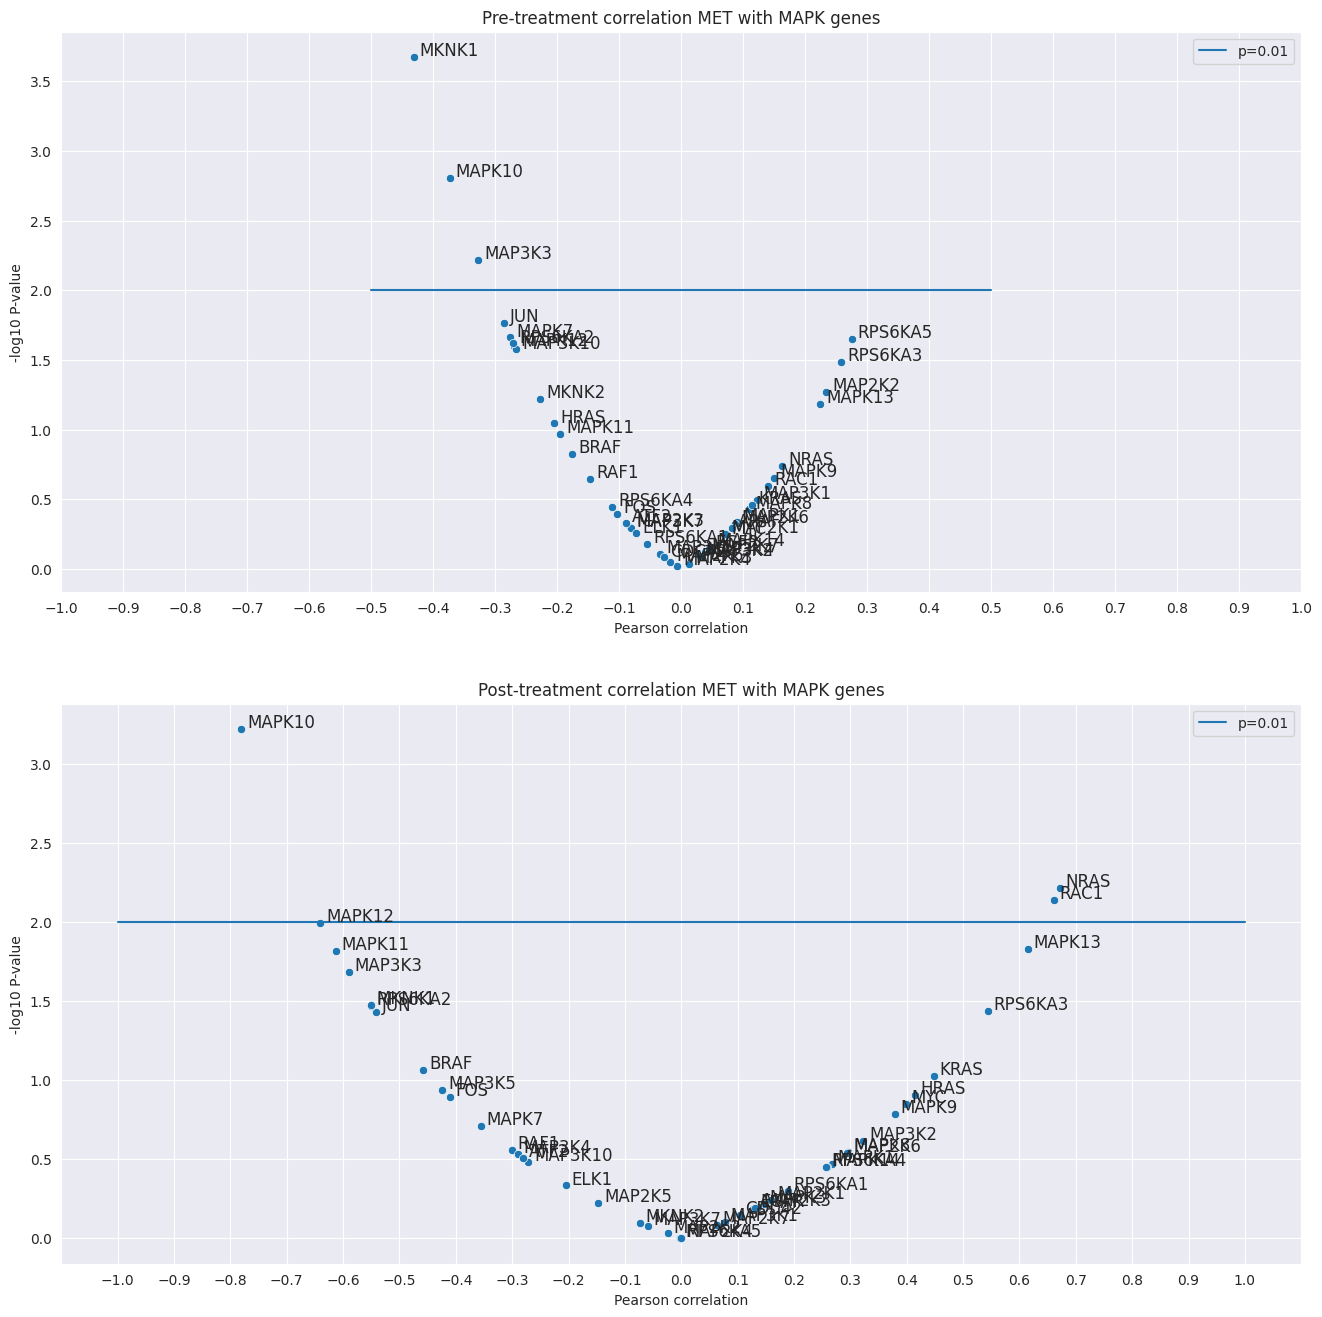

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [74]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

plot_correlations(log_tpms_pre, 'Pre-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/mapk_genes.txt',
                  xlim=(-0.5, 0.5), ax=axs[0])
plot_correlations(log_tpms_post, 'Post-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/mapk_genes.txt',
                  xlim=(-1, 1), ax=axs[1])

MET genes in total:  86
MET genes in our data:  81
MET genes in total:  86
MET genes in our data:  81


/tmp/ipykernel_14728/628154721.py:8: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])
/tmp/ipykernel_14728/628154721.py:8: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])


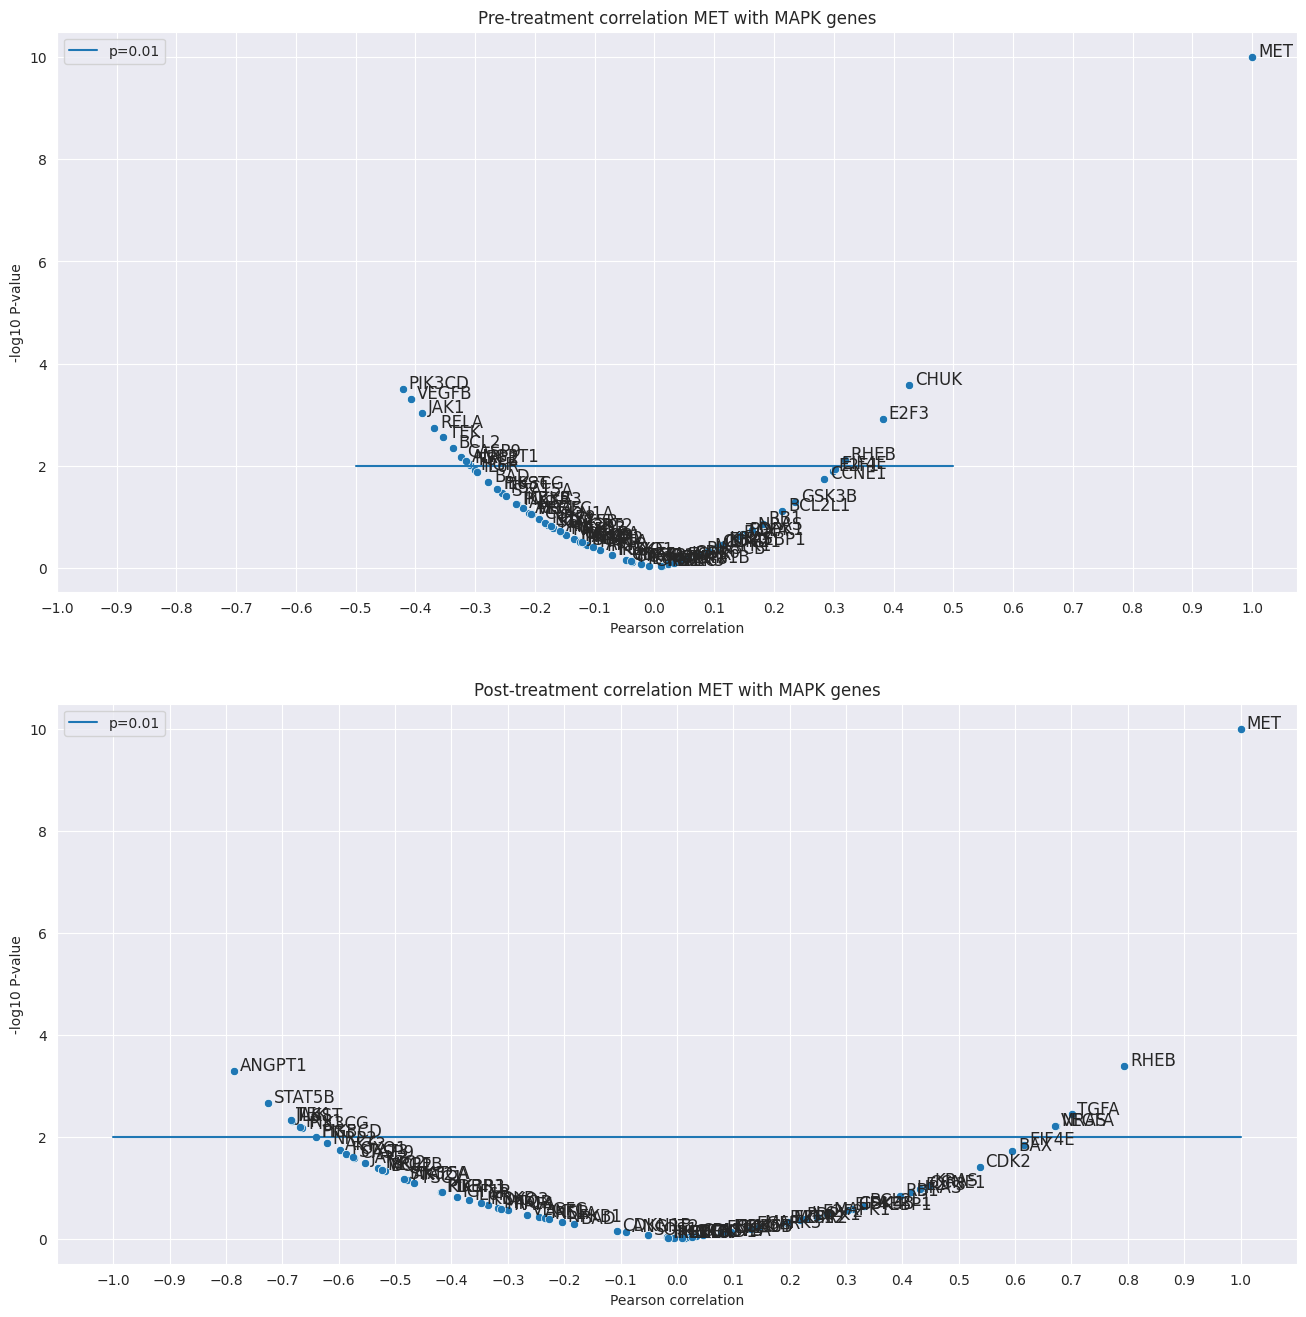

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [75]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))

plot_correlations(log_tpms_pre, 'Pre-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/pi3k_genes.txt',
                  xlim=(-0.5, 0.5), ax=axs[0])
plot_correlations(log_tpms_post, 'Post-treatment correlation MET with MAPK genes', 'MET', 'data/gene_lists/pi3k_genes.txt',
                  xlim=(-1, 1), ax=axs[1])

In [ ]:
ч